# Simultaneously fit multiple lightcurves with airmass detrending

Here we will fit multiple lightcurves simultaneously using the global fitter in exotic. We will set up bounds for each lightcurve that specify what parameters to fit along with 'global' bounds that are shared between all lightcurves. 

![](https://s3.amazonaws.com/aasie/images/0004-6256/164/5/null/ajac8deef3_hr.jpg)

This notebook will show you how to reproduce something similar to Figure 4 in a study on HD 80606 b, https://ui.adsabs.harvard.edu/abs/2022AJ....164..178P/abstract 

Please cite that paper if you use this code

## Find lightcurve data in the Exoplanet Watch Database

The command `get` will fetch priors, light curves and an ephemeris (O-C) for each target.

In [1]:
from exotic.api.ew import ExoplanetWatch
from IPython.display import display, Image

# This will load the results JSON from the link above
EW = ExoplanetWatch()
print(EW.target_list)

# names are case and space sensitive
target ='HAT-P-18 b'
result = EW.get(target)

# list the result properties
result.__dict__.keys()

Loaded 330 targets
['CoRoT-11 b', 'CoRoT-14 b', 'CoRoT-18 b', 'CoRoT-1 b', 'CoRoT-27 b', 'CoRoT-29 b', 'CoRoT-2 b', 'CoRoT-5 b', 'CoRoT-7 b', 'CoRoT-8 b', 'CoRoTID 223977153 b', 'EPIC 206042996 c', 'Gaia-1 b', 'Gaia-2 b', 'GJ 1214 b', 'GJ 3470 b', 'GJ 436 b', 'GPX-1 b', 'HAT-P-11 b', 'HAT-P-12 b', 'HAT-P-13 b', 'HAT-P-16 b', 'HAT-P-17 b', 'HAT-P-18 b', 'HAT-P-19 b', 'HAT-P-1 b', 'HAT-P-20 b', 'HAT-P-21 b', 'HAT-P-22 b', 'HAT-P-23 b', 'HAT-P-25 b', 'HAT-P-26 b', 'HAT-P-27 b', 'HAT-P-28 b', 'HAT-P-29 b', 'HAT-P-30 b', 'HAT-P-32 b', 'HAT-P-33 b', 'HAT-P-36 b', 'HAT-P-37 b', 'HAT-P-39 b', 'HAT-P-3 b', 'HAT-P-41 b', 'HAT-P-44 b', 'HAT-P-45 b', 'HAT-P-49 b', 'HAT-P-4 b', 'HAT-P-50 b', 'HAT-P-51 b', 'HAT-P-52 b', 'HAT-P-53 b', 'HAT-P-54 b', 'HAT-P-55 b', 'HAT-P-56 b', 'HAT-P-57 b', 'HAT-P-59 b', 'HAT-P-5 b', 'HAT-P-68 b', 'HAT-P-6 b', 'HAT-P-70 b', 'HAT-P-7 b', 'HAT-P-8 b', 'HAT-P-9 b', 'HATS-18 b', 'HATS-22 b', 'HATS-24 b', 'HATS-2 b', 'HATS-33 b', 'HATS-38 b', 'HATS-44 b', 'HATS-47 b', 'HAT

dict_keys(['raw_result', 'host', 'name', 'priors', 'timestamp', 'identifier', 'reduction_count', 'observation_count', 'ephemeris', 'observations'])

## Priors
A list of stellar and planetary parameters with references. These are used to calculate a light curve model with non-linear limb darkening.

In [2]:
result.priors

{'R*': {'units': 'Sol',
  'value': '0.75',
  'reference': 'Patel%20&amp;%20Espinoza%202022',
  'uncertainty': '0.04'},
 'RA': {'units': 'decimal',
  'value': '256.346376',
  'reference': None,
  'uncertainty': None},
 'Rp': {'units': 'R_Earth',
  'value': '10.73',
  'reference': 'ExoFOP-TESS%20TOI',
  'uncertainty': '0.74'},
 'T*': {'units': 'K',
  'value': '4803.0',
  'reference': 'Patel%20&amp;%20Espinoza%202022',
  'uncertainty': '80.0'},
 'Tc': {'units': 'BJD-TDB',
  'value': '2459743.853395',
  'reference': 'Fu%20et%20al.%202022',
  'uncertainty': '2.3e-05'},
 'DEC': {'units': 'decimal',
  'value': '33.0123251',
  'reference': None,
  'uncertainty': None},
 'Tcs': [{'units': 'BJD-TDB, BJD-UTC',
   'value': '2454715.022256667',
   'reference': 'Bonomo%20et%20al.%202017,%20Seeliger%20et%20al.%202015,%20Hartman%20et%20al.%202011',
   'uncertainty': '0.00026333333333333336'},
  {'units': 'BJD-TDB',
   'value': '2456411.49556',
   'reference': 'Ivshina%20&amp;%20Winn%202022',
   'uncer

In [3]:
result.ephemeris.keys()

dict_keys(['Tc', 'Tcs', 'files', 'notes', 'Period', 'Tc_err', 'epochs', 'Tcs_err', 'datasets', 'nea_tmids', 'residuals', 'timesaved', 'Period_err', 'nea_epochs', 'nea_tmids_err', 'nea_references', 'ephemeris_url'])

## Observations
A list of observations for each target. These are used to fit the light curve model to the data.

In [4]:
len(result.observations)

6

In [5]:
# list the properties
print(result.observations[0].__dict__.keys())

dict_keys(['raw_observation', 'name', 'files', 'filter', 'obscode', 'identifier', 'secondary_obscodes', 'errors', 'parameters', 'lightcurve_url', 'posterior_url'])


In [6]:
# print the best-fit parameters
priors = result.observations[0].parameters

In [7]:
# show the light curve
#for i in range(len(result.observations)):
#    display(Image(url=result.observations[i].lightcurve_url))

# Download the light curve data

In [8]:
time, flux, fluxerr, airmass, airmasscorr = result.observations[0].get_data()

Text(0, 0.5, 'Rel. Flux')

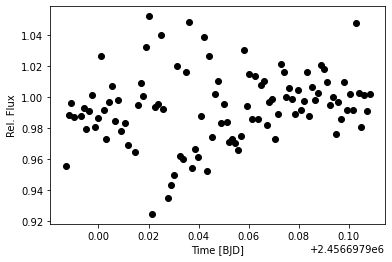

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plot the data after detrending
plt.plot(time, flux/airmasscorr, 'ko')
plt.xlabel("Time [BJD]")
plt.ylabel("Rel. Flux")

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...
    Done!
    Done!
	Updating:  ecc_planets.yaml
    Done!
	Updating:  ecc_stars.yaml
    Done!


Text(0, 0.5, 'Rel. Flux')

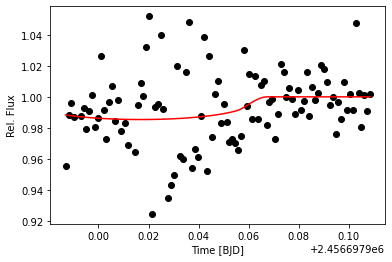

In [10]:
# let's over plot the transit model too
from exotic.api.elca import transit

plt.plot(time, flux/airmasscorr, 'ko')
plt.plot(time, transit(time, result.observations[0].parameters), 'r-')
plt.xlabel("Time [BJD]")
plt.ylabel("Rel. Flux")

## Fit a single lightcurve using EXOTIC

In [11]:
from exotic.api.elca import lc_fitter

# only define bounds for the "free" parameters during fitting
mybounds = {
    # [lower, upper]
    'rprs':[0,0.2],
    'tmid':[ result.ephemeris['Tc']-0.02,
             result.ephemeris['Tc']+0.02],
    'inc':[ priors['inc']-3, min(90,priors['inc']+3)],
    'a2':[-0.5,0.5] # airmass curvature
}

myfit = lc_fitter(time, flux, fluxerr, airmass,
                  result.observations[0].parameters, # priors
                  mybounds)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .74 [-122.0700..-122.0683]*| it/evals=5220/24470 eff=21.6867% N=400  0 
[ultranest] Likelihood function evaluations: 24526
[ultranest]   logZ = -130.5 +- 0.07228
[ultranest] Effective samples strategy satisfied (ESS = 2312.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] done iterating.


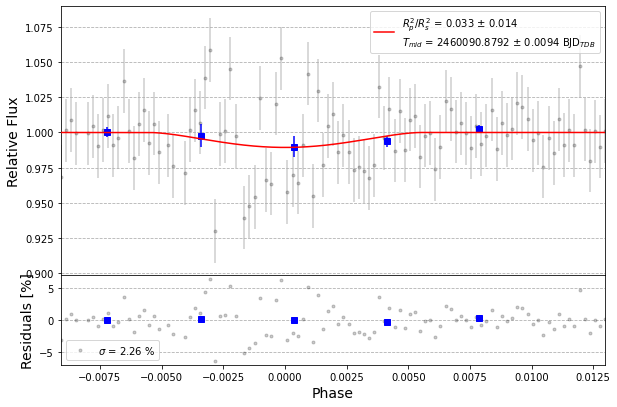

In [12]:
myfit.plot_bestfit()
plt.show()

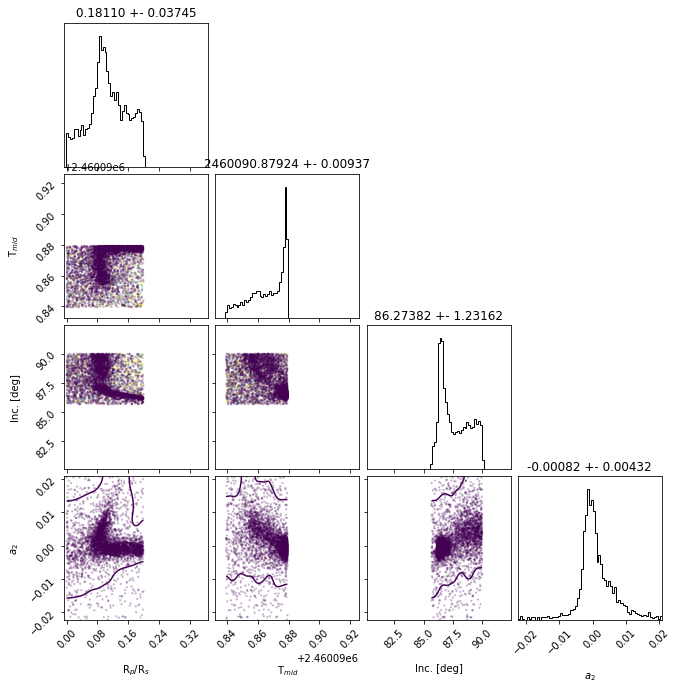

In [13]:
# show the posterior distributions
myfit.plot_triangle()
plt.show()

# Fit multiple light curves

We're going to optimize the multi-lightcurve fit by fitting the lightcurves simultaneously. This will allow us to fit for the same parameters across all lightcurves.

In [14]:
from astropy.time import Time
from copy import deepcopy
from exotic.api.elca import glc_fitter

# prep data for global fitter
input_data = []

# free parameters for each light curve
local_bounds = []

In [15]:
# fit the individual light curves from Exoplanet Watch and detrend airmass extinction
for n,obs in enumerate(result.observations):

    try:
        time, flux, fluxerr, airmass, airmasscorr = obs.get_data()
    except:
        data = obs.get_data()
        time, flux, fluxerr, airmass = data[:,0], data[:,1], data[:,2], data[:,3]

    # copy default priors
    prior = deepcopy(result.observations[n].parameters)

    # compute tmid closest to observations
    tmid = prior['tmid']
    per = prior['per']
    obs_time = 0.5*(time.min() + time.max())
    obs_tmid = tmid + per*np.round((obs_time - tmid)/per)

    # mask out nans and 0 errors
    mask = np.isnan(flux) | (fluxerr <= 0) | np.isnan(fluxerr) | (airmass <= 1)
    
    if mask.sum() == len(flux):
        continue

    time = time[~mask]
    flux = flux[~mask]
    fluxerr = fluxerr[~mask]
    airmass = airmass[~mask]

    # only define bounds for the "free" parameters during fitting
    mybounds = {
        # [lower, upper]
        'rprs':[0, prior['rprs']*2],
        'tmid':[ obs_tmid-0.05,
                 obs_tmid+0.05],
        'inc':[ priors['inc']-3, min(90,priors['inc']+3)],
        'a2':[-0.5,0.5] # airmass curvature
    }

    try:
        # fit the light curve
        myfit = lc_fitter(time, flux, fluxerr, airmass, priors, mybounds) 
    except:
        print(f"Failed to fit {obs.obscode['id']}")
        continue

    rprs2 = myfit.parameters['rprs']**2
    rprs2err = myfit.errors['rprs']*2*myfit.parameters['rprs']

    # residuals must be smaller than transit depth
    if myfit.res_stdev > prior['rprs']**2:
        print(f"Skipping {obs.obscode['id']} due to large residuals")
        continue
    elif rprs2-3*rprs2err < 0: # 3 sigma clip
        print(f"Skipping {obs.obscode['id']} due to null transit detection")
    elif np.std(flux) > 0.03:  # ignore noisy data
        print(f"Skipping {obs.obscode['id']} due to high scatter")
        continue
    else:
        prior = deepcopy(result.observations[n].parameters)

        # add data to list
        input_data.append({
            'time':time,
            'flux':myfit.detrended,
            'ferr':myfit.detrendederr,
            'airmass':np.zeros_like(time),
            'priors':prior,
            'name':f"{obs.obscode['id']}",

            # save individual fit parameters
            'parameters':myfit.parameters,
            'errors':myfit.errors,
            'res_std':myfit.res_stdev
        })

        # add parameter for individual airmass detrending
        local_bounds.append({}) 

        # print some timing info
        mint = Time(input_data[-1]['time'].min(),format='jd').isot
        maxt = Time(input_data[-1]['time'].max(),format='jd').isot
        maxphase = (input_data[-1]['time'].max() - prior['tmid'])/prior['per']
        minphase = (input_data[-1]['time'].min() - prior['tmid'])/prior['per']
        print(f"{input_data[-1]['name']} {len(input_data)} : {mint} ({minphase:.4f}) - {maxt} ({maxphase:.4f})")

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .30 [-121.4659..-121.4656]*| it/evals=5580/32323 eff=17.4796% N=400  0 
[ultranest] Likelihood function evaluations: 32366
[ultranest]   logZ = -130.8 +- 0.09641
[ultranest] Effective samples strategy satisfied (ESS = 3059.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
Skipping SPUA due to null transit detection
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-51.7093..-51.7093]*| it/evals=5280/27126 eff=19.7560% N=400 
[ultranest] Likelihood function evaluations: 27189
[ultranest]   logZ = -60.23 +- 0.07906
[ultranest] Effective samples strategy satisfied (ESS = 3187.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.
Skipping FMAA due to null transit detection
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-45.7071..-45.7068]*| it/evals=6200/20474 eff=30.8857% N=400   
[ultranest] Likelihood function evaluations: 20511
[ultranest]   logZ = -56.62 +- 0.1144
[ultranest] Effective samples strategy satisfied (ESS = 2110.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
SGEO 1 : 2020-05-14T04:15:11.052 (-0.0122) - 2020-05-14T07:19:13.231 (0.0110)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-29.6366..-29.6365]*| it/evals=5354/15389 eff=35.7195% N=400  0 
[ultranest] Likelihood function evaluations: 15395
[ultranest]   logZ = -38.36 +- 0.0901
[ultranest] Effective samples strategy satisfied (ESS = 2374.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.
FMAA 2 : 2020-07-08T05:32:41.098 (-0.0173) - 2020-07-08T10:17:39.919 (0.0187)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3  9 [-3.4993..-3.4992]*| it/evals=3360/8737 eff=40.3023% N=400    00 
[ultranest] Likelihood function evaluations: 8797
[ultranest]   logZ = -7.314 +- 0.06198
[ultranest] Effective samples strategy satisfied (ESS = 1414.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.
Skipping FMAA due to large residuals
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.8166..-27.8165]*| it/evals=6640/26022 eff=25.9152% N=400   
[ultranest] Likelihood function evaluations: 26033
[ultranest]   logZ = -39.74 +- 0.1057
[ultranest] Effective samples strategy satisfied (ESS = 2135.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
MBEB 3 : 2023-05-26T06:41:06.538 (-0.0150) - 2023-05-26T10:55:35.295 (0.0171)


## Run the next block of code only if you want to add TESS data to the global fit


In order to make lightcurves from TESS please inspect the file `tess.py` in the `examples/` directory. You will need to set up a new environment and then run the script based on instructions at the top of the file. Once you have the lightcurves, you can run the next block of code to add them to the global fit.

In [16]:
import glob
from pylightcurve import exotethys

# generate limb darkening coefficients for TESS
get_prior = lambda key: float(result.priors[key]['value'])
u0,u1,u2,u3 = exotethys(get_prior('LOGG'), get_prior('T*'), get_prior('FE/H'), 'TESS', method='claret', stellar_model='phoenix')

# get files from local directory
tess_lightcurves = glob.glob('output/HAT_P_18_b/*_AAVSO.txt')
print(f"Found {len(tess_lightcurves)} TESS light curves")

# add TESS data
for n,lc in enumerate(tess_lightcurves):

    # read in data
    time, flux, fluxerr, airmass, airmasscorr = np.loadtxt(lc, unpack=True, delimiter=',')
    prior = deepcopy(result.observations[0].parameters)
    prior['u0'] = u0
    prior['u1'] = u1
    prior['u2'] = u2
    prior['u3'] = u3
    prior['tmid'] = result.ephemeris['Tc']
    prior['per'] = result.ephemeris['Period']
    prior['a2'] = 0.0 # no airmass correction for TESS

    # compute tmid closest to observations
    tmid = prior['tmid']
    per = prior['per']
    obs_time = 0.5*(time.min() + time.max())
    obs_tmid = tmid + per*np.round((obs_time - tmid)/per)

    # only define bounds for the "free" parameters during fitting
    mybounds = {
        # [lower, upper]
        'rprs':[0, prior['rprs']*2],
        'tmid':[ obs_tmid-0.05,
                    obs_tmid+0.05],
        'inc':[ priors['inc']-3, min(90,priors['inc']+3)]
    }

    try:
        myfit = lc_fitter(time, flux, fluxerr, airmass, priors, mybounds) 
    except:
        print(f"Failed to fit {obs.obscode['id']}")
        continue
    
    # add data to list
    input_data.append({
        'time':time,
        'flux':flux,
        'ferr':fluxerr,
        'airmass':np.zeros(time.shape),
        'priors':prior,
        'name':f"TESS",

        # save individual fit parameters
        'parameters':myfit.parameters,
        'errors':myfit.errors,
        'res_std':myfit.res_stdev
    })

    # no airmass detrending
    local_bounds.append({})

    # print some timing info
    mint = Time(input_data[-1]['time'].min(),format='jd').isot
    maxt = Time(input_data[-1]['time'].max(),format='jd').isot
    maxphase = (input_data[-1]['time'].max() - prior['tmid'])/prior['per']
    minphase = (input_data[-1]['time'].min() - prior['tmid'])/prior['per']
    print(f"{input_data[-1]['name']} {len(input_data)} : {mint} ({minphase:.4f}) - {maxt} ({maxphase:.4f})")

PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Found 8 TESS light curves
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .80 [-157.8666..-157.8666]*| it/evals=6080/11762 eff=53.5117% N=400 
[ultranest] Likelihood function evaluations: 11788
[ultranest]   logZ = -168.5 +- 0.1001
[ultranest] Effective samples strategy satisfied (ESS = 1856.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 4 : 2020-06-27T02:11:40.031 (-193.0396) - 2020-06-27T12:39:39.087 (-192.9604)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .15 [-157.2417..-157.2417]*| it/evals=5920/12077 eff=50.6980% N=400  
[ultranest] Likelihood function evaluations: 12119
[ultranest]   logZ = -167.4 +- 0.08644
[ultranest] Effective samples strategy satisfied (ESS = 1852.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.
TESS 5 : 2020-07-02T14:23:27.809 (-192.0396) - 2020-07-03T00:49:26.823 (-191.9606)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .41 [-195.5038..-195.5038]*| it/evals=6120/12235 eff=51.7110% N=400 
[ultranest] Likelihood function evaluations: 12299
[ultranest]   logZ = -206.2 +- 0.1086
[ultranest] Effective samples strategy satisfied (ESS = 1940.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
TESS 6 : 2020-06-16T01:47:59.015 (-195.0397) - 2020-06-16T12:15:58.478 (-194.9605)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .16 [-166.3629..-166.3626]*| it/evals=6080/12591 eff=49.8729% N=400  
[ultranest] Likelihood function evaluations: 12631
[ultranest]   logZ = -176.9 +- 0.1157
[ultranest] Effective samples strategy satisfied (ESS = 1882.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
TESS 7 : 2020-05-19T12:52:04.268 (-200.0394) - 2020-05-19T23:18:04.671 (-199.9605)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .48 [-135.5847..-135.5844]*| it/evals=6080/12605 eff=49.8156% N=400  
[ultranest] Likelihood function evaluations: 12619
[ultranest]   logZ = -146.1 +- 0.144
[ultranest] Effective samples strategy satisfied (ESS = 1850.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
TESS 8 : 2020-05-25T01:04:08.969 (-199.0394) - 2020-05-25T11:30:09.308 (-198.9604)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .10 [-122.1696..-122.1696]*| it/evals=6120/11828 eff=53.5527% N=400  
[ultranest] Likelihood function evaluations: 11896
[ultranest]   logZ = -132.9 +- 0.1199
[ultranest] Effective samples strategy satisfied (ESS = 1917.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
TESS 9 : 2020-06-05T01:26:08.696 (-197.0395) - 2020-06-05T11:52:08.584 (-196.9606)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .52 [-159.5782..-159.5782]*| it/evals=6080/12154 eff=51.7271% N=400  
[ultranest] Likelihood function evaluations: 12211
[ultranest]   logZ = -170.2 +- 0.09919
[ultranest] Effective samples strategy satisfied (ESS = 1861.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 10 : 2020-06-10T13:38:05.428 (-196.0395) - 2020-06-11T00:04:04.923 (-195.9605)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-76.8887..-76.8885]*| it/evals=6030/12309 eff=50.6340% N=400    0 
[ultranest] Likelihood function evaluations: 12331
[ultranest]   logZ = -87.35 +- 0.1215
[ultranest] Effective samples strategy satisfied (ESS = 1868.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
TESS 11 : 2020-05-14T03:51:59.068 (-201.0153) - 2020-05-14T11:05:59.339 (-200.9606)


In [17]:
# bounds shared by all light curves
global_bounds = {
    'rprs':(prior['rprs']*0.75, prior['rprs']*1.33),
    'inc':(prior['inc']-3, min(90,prior['inc']+3)),
    'per':( result.ephemeris['Period']-0.001,
            result.ephemeris['Period']+0.001),
    'tmid':( result.ephemeris['Tc']-0.01,
             result.ephemeris['Tc']+0.01),
}

global_fit = glc_fitter(input_data, global_bounds, local_bounds, individual_fit=False, verbose=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  248.53 [-1248.6456..-1248.6455]*| it/evals=8005/20375 eff=40.0751% N=400 
[ultranest] Likelihood function evaluations: 20385
[ultranest]   logZ = -1264 +- 0.1297
[ultranest] Effective samples strategy satisfied (ESS = 2049.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.


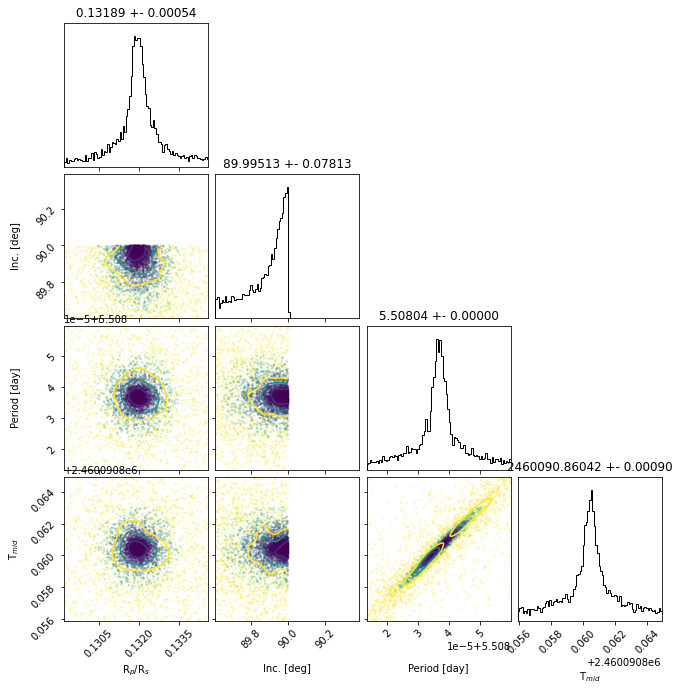

In [18]:
global_fit.plot_triangle()
plt.savefig("posteriors.png",facecolor='white')

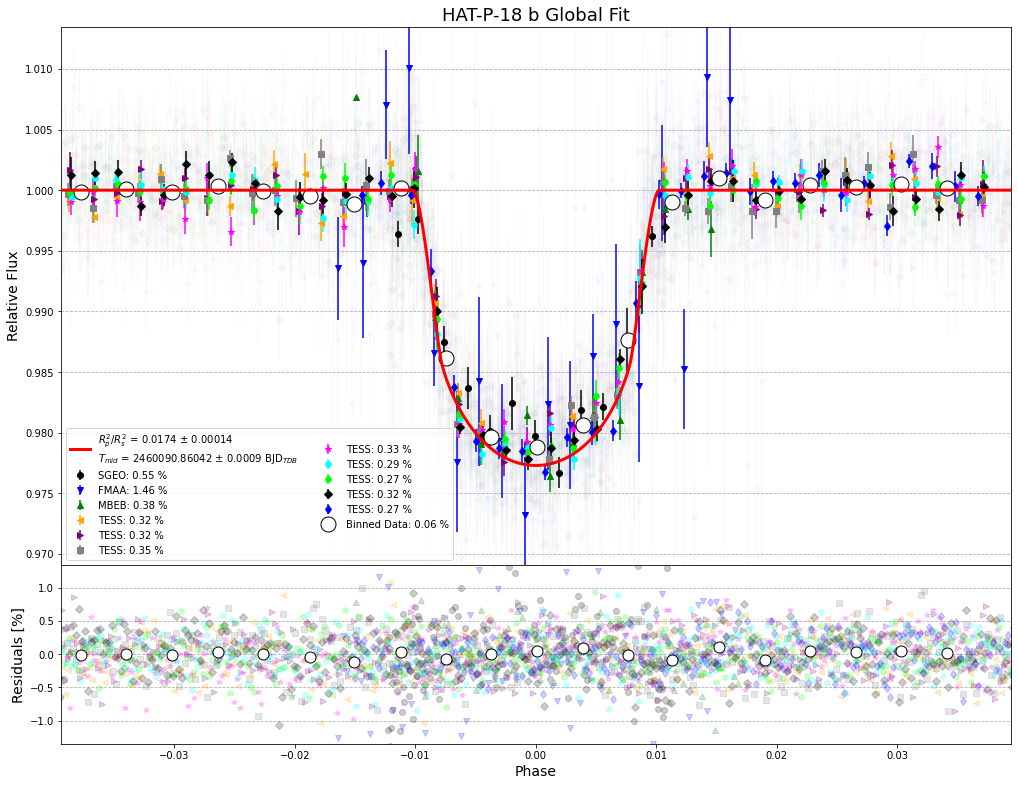

In [19]:
global_fit.plot_bestfit(alpha=0.025, bin_dt = 15./60/24, title=f"{target} Global Fit",phase_limits='median')
plt.savefig("bestfit.png",facecolor='white')

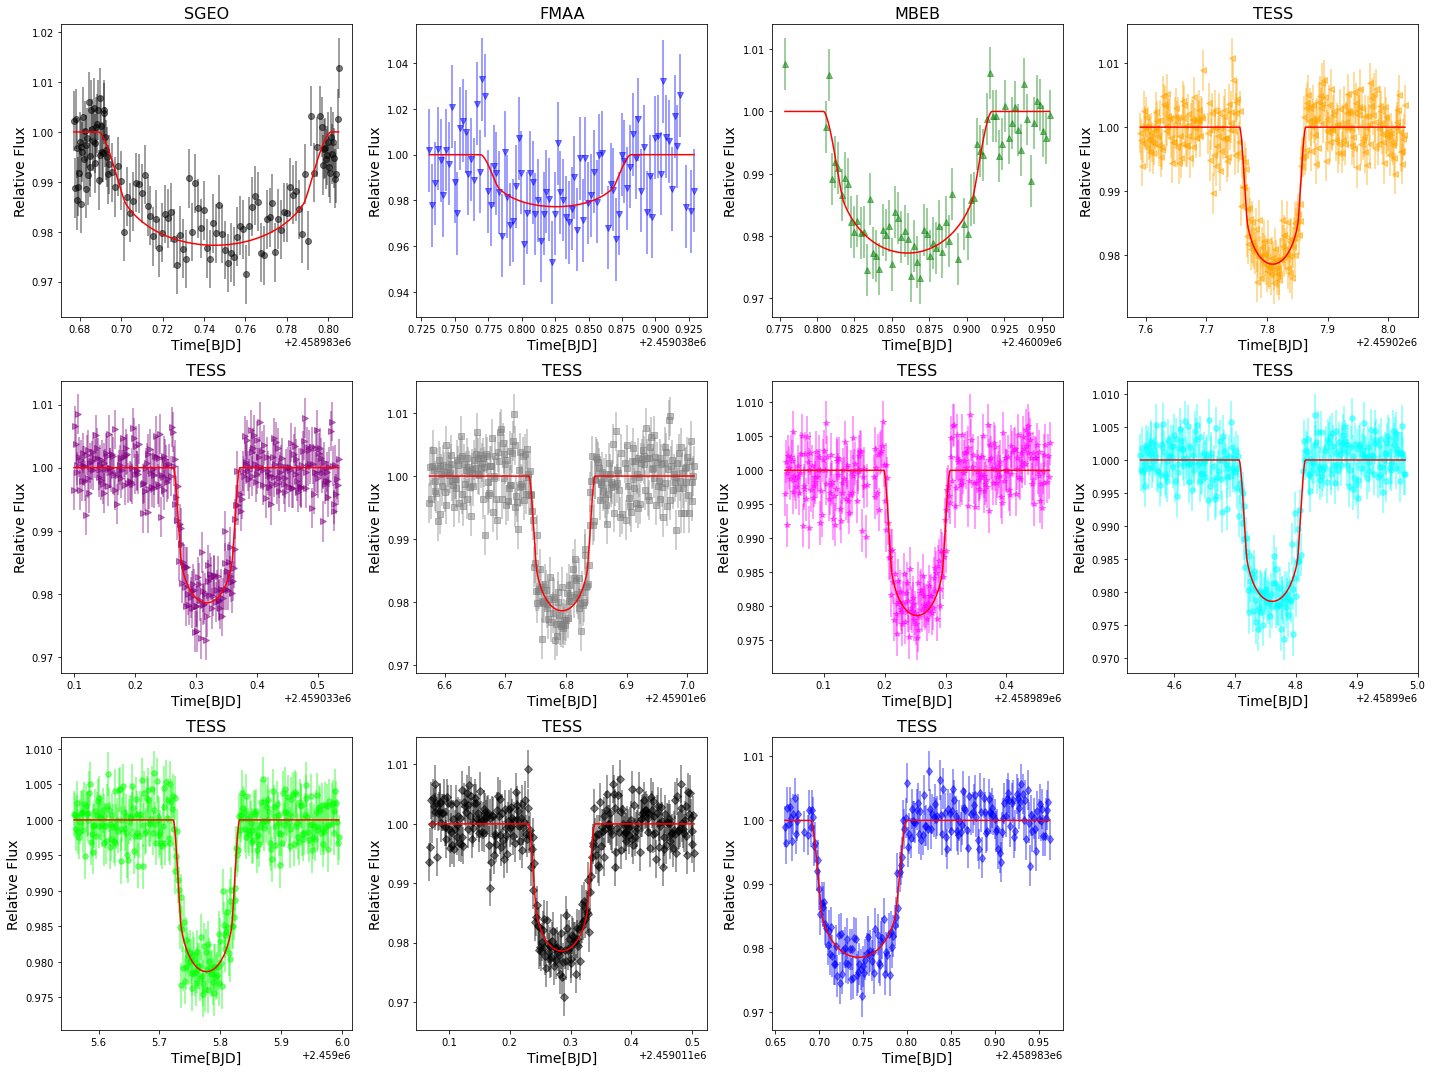

In [20]:
global_fit.plot_bestfits()
plt.savefig("bestfits.png",facecolor='white')

## LaTeX Output for Global Fit

In [21]:
# create latex formatted table for global fit parameters
for key in global_fit.errors:
    print(f"{key} & {global_fit.parameters[key]:.5f} $\pm$ {global_fit.errors[key]:.7f} \\\\")

rprs & 0.13189 $\pm$ 0.0005386 \\
inc & 89.99513 $\pm$ 0.0781293 \\
per & 5.50804 $\pm$ 0.0000047 \\
tmid & 2460090.86042 $\pm$ 0.0009035 \\


In [22]:
# create column headers
header = "Name"
for key in input_data[0]['errors']:
    # skip airmass parameters
    if 'a1' in key or 'a2' in key:
        continue
    header += f" & {key}"
header += " & $\sigma_{res}$"
header += " \\\\"
print(header)

# create latex formatted string
for lcdata in input_data:
    fstring = lcdata['name']
    for key in lcdata['errors']:

        # skip airmass parameters
        if 'a1' in key or 'a2' in key:
            continue

        # add to string
        fstring += f" & {lcdata['parameters'][key]:.6f} $\pm$ {lcdata['errors'][key]:.6f}"

    # add res_std
    fstring += f" & {lcdata['res_std']:.6f}"
    fstring += f" \\\\"
    print(fstring)


Name & rprs & tmid & inc & $\sigma_{res}$ \\
SGEO & 0.113771 $\pm$ 0.005725 & 2458983.744435 $\pm$ 0.001462 & 89.914842 $\pm$ 0.334780 & 0.005024 \\
FMAA & 0.118395 $\pm$ 0.018315 & 2459038.827321 $\pm$ 0.008038 & 89.962872 $\pm$ 0.799651 & 0.014574 \\
MBEB & 0.122943 $\pm$ 0.006676 & 2460090.860987 $\pm$ 0.001121 & 89.932281 $\pm$ 0.297136 & 0.003730 \\
TESS & 0.127349 $\pm$ 0.001489 & 2459027.809680 $\pm$ 0.000630 & 89.999874 $\pm$ 0.144387 & 0.003251 \\
TESS & 0.126611 $\pm$ 0.001590 & 2459033.318277 $\pm$ 0.000651 & 89.992520 $\pm$ 0.138952 & 0.003269 \\
TESS & 0.128969 $\pm$ 0.001461 & 2459016.792211 $\pm$ 0.000571 & 89.999392 $\pm$ 0.146833 & 0.003566 \\
TESS & 0.125108 $\pm$ 0.001689 & 2458989.252383 $\pm$ 0.000634 & 89.969843 $\pm$ 0.141543 & 0.003347 \\
TESS & 0.131543 $\pm$ 0.001698 & 2458994.760425 $\pm$ 0.000634 & 89.975703 $\pm$ 0.133028 & 0.002986 \\
TESS & 0.128138 $\pm$ 0.001440 & 2459005.777342 $\pm$ 0.000628 & 89.978895 $\pm$ 0.141750 & 0.002807 \\
TESS & 0.129981 $\p

## Mid-transit times and uncertainties from Nasa Exoplanet Archive

In [23]:
nea_tmids = []
nea_tmids_err = []

for i in range(len(result.ephemeris['nea_tmids'])):
    clean_ref = result.ephemeris['nea_references'][i].replace('%20', ' ').replace('&amp;', '&')

    # remove ExoFOP-TESS values since we're using TESS data itself, no need to double count
    if 'ExoFOP-TESS' in clean_ref:
        continue

    nea_tmids.append(result.ephemeris['nea_tmids'][i])
    nea_tmids_err.append(result.ephemeris['nea_tmids_err'][i])

    print(f"{float(result.ephemeris['nea_tmids'][i]):.6f} +- {float(result.ephemeris['nea_tmids_err'][i]):.6f} : {clean_ref}")

2454715.022257 +- 0.000263 : Bonomo et al. 2017, Seeliger et al. 2015, Hartman et al. 2011
2456411.495560 +- 0.000530 : Ivshina & Winn 2022
2457276.256460 +- 0.000100 : Kokori et al. 2022
2457507.592196 +- 0.000194 : Kirk et al. 2017
2459033.317350 +- 0.000210 : Patel & Espinoza 2022
2459743.853395 +- 0.000023 : Fu et al. 2022


## Fit an ephemeris to the mid-transit times

T_next = T_0 + n * Period

[ultranest] Sampling 420 live points from prior ...


/Users/kpearson/anaconda3/lib/python3.8/site-packages/exotic/api/nested_linear_fitter.py:49: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[ultranest] Explored until L=-3e+01  
[ultranest] Likelihood function evaluations: 8975
[ultranest]   logZ = -42.41 +- 0.09703
[ultranest] Effective samples strategy satisfied (ESS = 1645.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.


/Users/kpearson/anaconda3/lib/python3.8/site-packages/exotic/api/nested_linear_fitter.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dt)


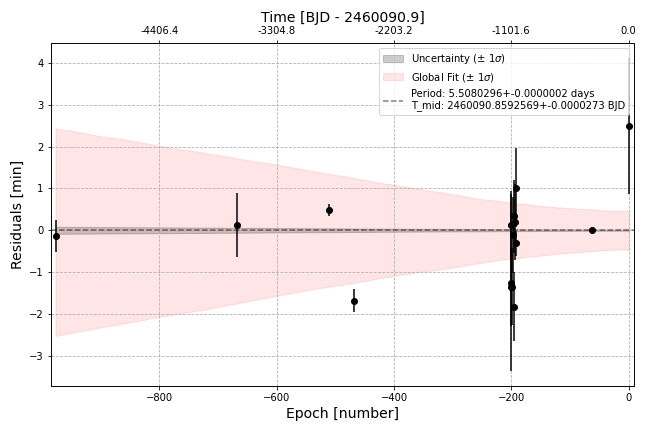

In [24]:
from exotic.api.nested_linear_fitter import linear_fitter

# min and max values to search between for fitting the ephemeris
bounds = {
    'm':[ # orbital period
        global_fit.parameters['per']-10*global_fit.errors['per'], 
        global_fit.parameters['per']+10*global_fit.errors['per']
    ], 
    'b':[ # mid-transit time
        global_fit.parameters['tmid']-10*global_fit.errors['tmid'],
        global_fit.parameters['tmid']+10*global_fit.errors['tmid']
    ] 
}

# used to plot red overlay in O-C figure
prior = {
    'm':[global_fit.parameters['per'], global_fit.errors['per']],   # value from global
    'b':[global_fit.parameters['tmid'], global_fit.errors['tmid']]  # value from WLS
}

# extract data from individual light curves in global fit
tmids = [lcfit['parameters']['tmid'] for lcfit in input_data]
tmids_err = [lcfit['errors']['tmid'] for lcfit in input_data]
rprs2 = [lcfit['parameters']['rprs']**2 for lcfit in input_data]
rprs = [lcfit['parameters']['rprs'] for lcfit in input_data]
rprs_err = [lcfit['errors']['rprs'] for lcfit in input_data]
res_stdev = [lcfit['res_std'] for lcfit in input_data]
name = [lcfit['name'] for lcfit in input_data]
tmids_err = np.array(tmids_err)

# filter bad data
mask = (res_stdev < np.mean(rprs2)) & (np.mean(rprs) > 5 * np.mean(rprs_err)) & (tmids_err*24*60<10)

# apply mask
tmids = np.array(tmids)[mask]
tmids_err = np.array(tmids_err)[mask]

# combine the good data from reprocessing of Exoplanet Watch and NASA Exoplanet Archive
tmids = np.array(list(tmids) + nea_tmids, dtype=float)
tmids_err = np.array(list(tmids_err) + nea_tmids_err, dtype=float)

# fit the data and compare ephemeris to global light curve fit
lf = linear_fitter( tmids, tmids_err, bounds, prior=prior )

# plot the O-C diagram
fig,ax = lf.plot_oc(prior_name='Global Fit')
plt.tight_layout()
plt.savefig("oc_global.png",facecolor='white')
plt.close()
Image("oc_global.png")

## Search for periodic signals in the O-C data

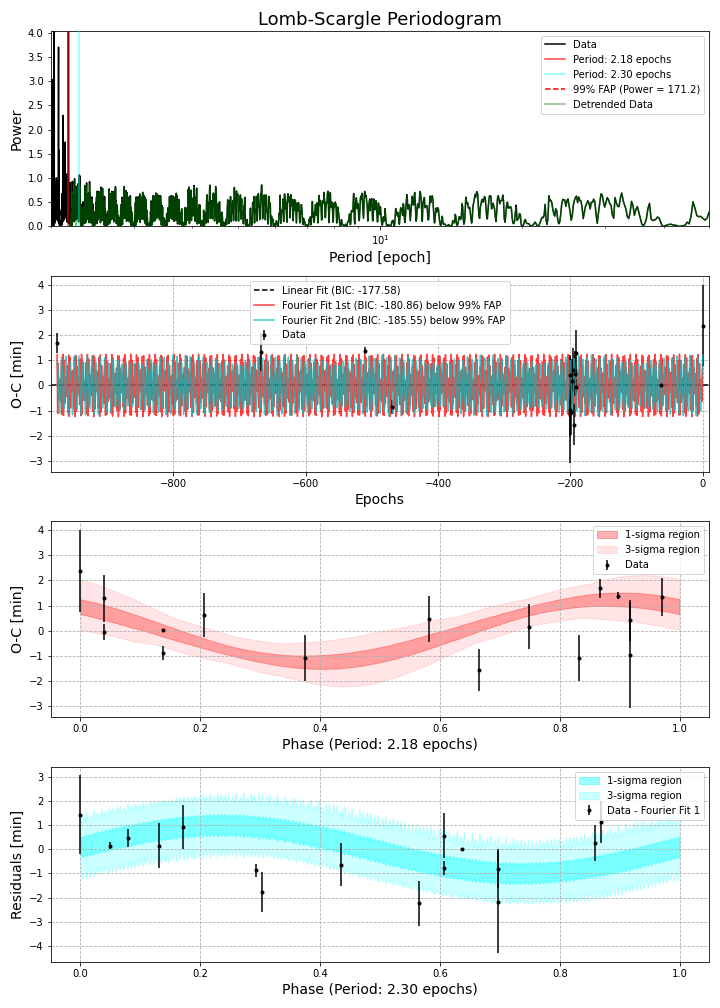

In [25]:
fig,ax = lf.plot_periodogram()
plt.tight_layout()
plt.savefig("plot_periodogram.png",facecolor='white')
plt.close()
Image("plot_periodogram.png")